In [1]:
import os
import requests
from tqdm import tqdm
import pandas as pd
import pycountry_convert as pc
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from cycler import cycler

resolutions_issues = {'me': 'Palestinian conflict', 
                      'nu': 'Nuclear weapons and nuclear material', 
                      'di': 'Arms control and disarmament',
                      'co': 'Colonialism',
                      'hr': 'Human rights',
                      'ec': 'Economic Development',
                      'N/A': 'Not specified'}

resolutions_issues_color = {'me': 'salmon', 
                            'nu': 'yellow', 
                            'di': 'teal',
                            'co': 'orchid',
                            'hr': 'navy',
                            'ec': 'orange',
                            'N/A': 'black'}

continents_colors = {'North America': 'yellow',
                     'South America': 'forestgreen',
                     'Europe': 'royalblue',
                     'Africa': 'plum',
                     'Asia': 'darkorange',
                     'Oceania': 'firebrick'}

cycler_colors = ['royalblue','firebrick','forestgreen','olive']


def load_un_dataset(un_data_path, initial_year=1946, final_year=2018, remove_nonmembers=True, remove_nonpresent=False, unknown_votes=False):
    
    if os.path.isdir(os.path.dirname(un_data_path)):
        if not os.path.exists(un_data_path):
            download_un_dataset(un_data_path)
    else:
        raise Exception("Provided path for UN dataset is not reachable")
    
    # Load data    
    votes_df = pd.read_csv(un_data_path, low_memory=False, encoding='latin-1', index_col=0)
    # Keep only desired years
    votes_df = votes_df[votes_df.year>=initial_year]
    votes_df = votes_df[votes_df.year<=final_year]
    
    if remove_nonmembers:
        # Remove votes by nonmembers
        votes_df = votes_df[votes_df.vote!=9]
    
    if remove_nonpresent:
        # Remove votes by nonmembers
        votes_df = votes_df[votes_df.vote!=8]
        
    # Edges in graph represent an affirmative vote
    votes_df['weight'] = (votes_df.vote==1)
    
    if unknown_votes:
        # Voters preference is assumed unknown if it is an abstention or voter is not present
        votes_df['unknown'] =  (votes_df.vote==2) | (votes_df.vote==8)
    
    
    continents_dict = get_continents_dict(votes_df)
    votes_df['Continent'] = votes_df['Country'].map(continents_dict)
    aux = pd.get_dummies(votes_df['Continent']).astype(int)
    votes_df['continent_vector']=aux[['Africa','Asia','Europe','North America','Oceania','South America']].apply(lambda row: np.array(row), axis=1)
    votes_df['continent_vector'] = votes_df['continent_vector'].apply(lambda arr: np.concatenate((arr, np.zeros(6))))
    
    votes_df['res_features'] = votes_df[['me','nu','di','co','hr','ec']].apply(lambda row: np.array(row), axis=1)
    votes_df['res_features'] = votes_df['res_features'].apply(lambda arr: np.concatenate((np.zeros(6), arr)))
    

    return votes_df

        
def download_un_dataset(filename='UNVotes-1.csv', data_url='https://dataverse.harvard.edu/api/access/datafile/6358426'):
    # Code from https://gist.github.com/yanqd0/c13ed29e29432e3cf3e7c38467f42f51
    response = requests.get(data_url, stream=True)
    total_size = int(response.headers.get('content-length',0))
    with open(filename, "wb") as f, tqdm(desc='Downloading UN dataset', total=total_size, unit='B', unit_divisor=1024, unit_scale=True) as pbar:
        for un_data in response.iter_content(chunk_size=1024):
            size = f.write(un_data)
            pbar.update(size)
            
def get_continents_dict(votes_df):
    continents_dict = {}
    countries = votes_df.Country.unique()
    for country in countries: 
        try:
            continent_code = pc.country_alpha2_to_continent_code(pc.country_alpha3_to_country_alpha2(country))
            continents_dict[country] = pc.convert_continent_code_to_continent_name(continent_code)
        except:
            continue
            # print(pais)
            
    continents_dict['DDR'] = 'Europe'
    continents_dict['CSK'] = 'Europe'
    continents_dict['YUG'] = 'Europe'
    continents_dict['EAZ'] = 'Africa'
    continents_dict['YAR'] = 'Asia'
    continents_dict['TLS'] = 'Asia'
    
    return continents_dict

def get_countries_name_conversion_dict(votes_df):
    countries = votes_df.Countryname.unique()
    conversion_dict = {}
    for country in countries: 
        conversion_dict[country] = votes_df[votes_df.Countryname==country].Country.unique()[0]
        
    return conversion_dict

def create_un_graphs(votes_df):
    
    continents_dict = get_continents_dict(votes_df)
    conversion_dict = get_countries_name_conversion_dict(votes_df)
    
    all_graphs = {}
    
    edge_attr = ['weight', 'unknown'] if 'unknown' in votes_df.columns else 'weight'    
    
        
    g = nx.from_pandas_edgelist(votes_df,source='Countryname',target='resid',edge_attr=edge_attr,create_using=nx.DiGraph())
    if g.number_of_edges()>0:
        
        countries_list = votes_df.Countryname.unique()
        
        # Add country's code and continent as graph attributes
        countries_codes = {}
        countries_continents = {}
        nodes_colors = {}
        node_types = {}
        country_features = {}
        for country in countries_list:
            countries_codes[country] = conversion_dict[country]
            countries_continents[country] = continents_dict[conversion_dict[country]]
            nodes_colors[country] = continents_colors[countries_continents[country]]
            node_types[country] = "country"
            country_features[country] = votes_df[votes_df.Countryname==country]['continent_vector'].mean()
            
        nx.set_node_attributes(g, countries_codes, name='country code')
        nx.set_node_attributes(g, countries_continents, name='continent')
        nx.set_node_attributes(g, country_features, name='country_features') 
        
        # Add resolution's issue as graph attribute
        resolutions_list = votes_df.resid.unique()
        resolutions_issues_dict = {}
        important_resolutions_dict = {}
        resolutions_features = {}

        
        for resolution_id in resolutions_list:
            df_votes_sum = votes_df[votes_df.resid==resolution_id][['me','nu','di','co','hr','ec']].sum()
            if df_votes_sum.max()>0:
                resolutions_issues_dict[resolution_id] = df_votes_sum.idxmax()
            else:
                resolutions_issues_dict[resolution_id] = 'N/A'
                
            nodes_colors[resolution_id] = resolutions_issues_color[resolutions_issues_dict[resolution_id]]
            resolutions_features[resolution_id] = votes_df[votes_df.resid==resolution_id]['res_features'].mean()
            node_types[resolution_id] = "resolution"
            
            important_vote = votes_df[votes_df.resid==resolution_id]['importantvote'].max()
            if important_vote > 0:
                important_resolutions_dict[resolution_id] = True
            else:
                important_resolutions_dict[resolution_id] = False
        
        nx.set_node_attributes(g, resolutions_issues_dict,name='issue code')
        nx.set_node_attributes(g, nodes_colors, name='color')
        nx.set_node_attributes(g, important_resolutions_dict, name='important vote')
        nx.set_node_attributes(g, node_types, name='type') 
        nx.set_node_attributes(g, resolutions_features, name='res_features') 
        
            
    return g

In [2]:
votes_df = load_un_dataset('data/UNVotes-1.csv', unknown_votes=True)
votes_df.head()

,rcid,ccode,member,vote,Country,Countryname,year,session,abstain,yes,...,hr,co,ec,ident,resid,weight,unknown,Continent,continent_vector,res_features
1,3,2,1.0,1,USA,United States of America,1946,1,4.0,29.0,...,0,0,0,0.0,1001,True,False,North America,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,20,1.0,3,CAN,Canada,1946,1,4.0,29.0,...,0,0,0,0.0,1001,False,False,North America,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,3,40,1.0,1,CUB,Cuba,1946,1,4.0,29.0,...,0,0,0,0.0,1001,True,False,North America,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,3,41,1.0,1,HTI,Haiti,1946,1,4.0,29.0,...,0,0,0,0.0,1001,True,False,North America,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,3,42,1.0,1,DOM,Dominican Republic,1946,1,4.0,29.0,...,0,0,0,0.0,1001,True,False,North America,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# 1980

## Removing countries

In [76]:
# all_graphs = create_un_graphs(votes_df[votes_df.year==1980])
# all_graphs = create_un_graphs(votes_df[votes_df.year==2000])
all_graphs = create_un_graphs(votes_df[votes_df.year==2018])


In [77]:
G = all_graphs.to_undirected()
# rename nodes
mapping = {node: i for i, node in enumerate(G.nodes())}
G_ = nx.relabel_nodes(G, mapping)

country_indexes = []
res_indexes = []
features = []

for node, data in G_.nodes(data=True):
    if data["type"] == "country":
        country_indexes.append(node)
        features.append(data['country_features'])
    else:
        res_indexes.append(node)
        features.append(data['res_features'])


unknown_edges = []

for u, v, data in G_.edges(data=True):
    if data['unknown']:
        unknown_edges.append((u,v))
        unknown_edges.append((v,u))
    

adj_matrix = nx.adjacency_matrix(G).todense().astype(int)

len(country_indexes), len(res_indexes), adj_matrix.shape[0]

(193, 95, 288)

In [78]:
## Create mask with unknown country votes

import torch
import random

num_nodes = adj_matrix.shape[0]

edge_index = torch.tensor(adj_matrix).nonzero().t().contiguous()

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
mask_unknown = torch.ones([num_nodes,num_nodes]).squeeze(0)

random.seed(42)
missing_countries = random.sample(country_indexes, 30)

for i in missing_countries:
    votos = (torch.rand(1, num_nodes) < 0.2).int()
    mask[i,:] = votos
    mask[:,i] = votos
    
for edge in unknown_edges:
    u, v = edge
    mask_unknown[u,v] = 0
    
mask = mask*mask_unknown # Me aseguro que los unknown formen parte de la mask
inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask)*mask_unknown # Me aseguro no predecir sobre los unknown

### ASE Embeddings

In [79]:
## Calculate ASE Embeddings

from torch_geometric.utils import to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 

d = 4

## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)

torch.norm((x_ase@Q@x_ase.T - to_dense_adj(edge_index, max_num_nodes=num_nodes).squeeze(0))*mask)

tensor([[-1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.]])


tensor(273.8760)

### GRDPG Embeddings

In [80]:
import sys
sys.path.append("../")
from models.RDPG_GD import GRDPG_GD_Armijo

x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous(), max_num_nodes=num_nodes).squeeze(0)))

Iteraciones:  77
Loss:  tensor(23.2701)


### GLASE Embeddings

In [81]:
## Calculate GLASE Embeddings
import sys
sys.path.append("../")
from models.GLASE_unshared_normalized import gLASE 

gd_steps = 10
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 1000

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index, max_num_nodes=num_nodes).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)

x_glase = out.detach()
print("Loss: ", torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous(), max_num_nodes=num_nodes).squeeze(0)))

tensor(255.2188, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(31.2760, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(27.9443, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(26.4359, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(25.9807, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(25.7693, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(24.8585, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(24.7227, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(24.4749, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(24.4509, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Loss:  tensor(24.3155, device='cuda:0')


### Link prediction

In [82]:
## Create feature tensor 
features = torch.tensor(features)

## Split Train, Val, Test
from torch_geometric.data import Data
import torch_geometric.transforms as T

device = 'cuda'

masked_edge_index = masked_adj.nonzero().t().contiguous()

data = Data(x=features.float(), x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)
# torch.manual_seed(42)
# random_features=torch.rand([num_nodes, 12])
# data = Data(x=random_features.float(), x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

transform = T.Compose([
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])

train_data, val_data, test_data = transform(data)

#### GCN Embeddings

In [83]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(12, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

## Predict on entire masked graph
z = model.encode(data.x, data.edge_index)
final_edge_index = model.decode_all(z)

predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
# (adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2
((adj_matrix*inverted_mask_matrix)[missing_countries] == (predicted_adj*inverted_mask_matrix)[missing_countries]).sum()/len(missing_countries)/num_nodes

Epoch: 020, Loss: 0.6675, Val: 0.7632, Test: 0.7315
Epoch: 040, Loss: 0.6558, Val: 0.7199, Test: 0.6878
Epoch: 060, Loss: 0.6504, Val: 0.7203, Test: 0.6914
Epoch: 080, Loss: 0.6484, Val: 0.7182, Test: 0.6917
Epoch: 100, Loss: 0.6473, Val: 0.7080, Test: 0.6819
Final Test: 0.8015


tensor(0.6826)

#### ASE Embeddings

In [84]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(d+12, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_ase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_ase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_ase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
# (adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2
((adj_matrix*inverted_mask_matrix)[missing_countries] == (predicted_adj*inverted_mask_matrix)[missing_countries]).sum()/len(missing_countries)/num_nodes

Epoch: 020, Loss: 0.6673, Val: 0.7484, Test: 0.7189
Epoch: 040, Loss: 0.6441, Val: 0.7297, Test: 0.6968
Epoch: 060, Loss: 0.6271, Val: 0.7358, Test: 0.7186
Epoch: 080, Loss: 0.6263, Val: 0.7384, Test: 0.7226
Epoch: 100, Loss: 0.6242, Val: 0.7285, Test: 0.7123
Final Test: 0.7699


tensor(0.6701)

#### GLASE Embeddings

In [85]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(d+12, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_glase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_glase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_glase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)


## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_glase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)

predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
# (adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2
((adj_matrix*inverted_mask_matrix)[missing_countries] == (predicted_adj*inverted_mask_matrix)[missing_countries]).sum()/len(missing_countries)/num_nodes

Epoch: 020, Loss: 0.6747, Val: 0.7874, Test: 0.7565
Epoch: 040, Loss: 0.6600, Val: 0.7612, Test: 0.7288
Epoch: 060, Loss: 0.6515, Val: 0.7382, Test: 0.7088
Epoch: 080, Loss: 0.6485, Val: 0.7271, Test: 0.6984
Epoch: 100, Loss: 0.6490, Val: 0.7256, Test: 0.6966
Final Test: 0.7856


tensor(0.6850)

#### GRDPG Embeddings

In [91]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(d+12, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_grdpg), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_grdpg), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_grdpg), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_grdpg), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)

predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
# (adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2

((adj_matrix*inverted_mask_matrix)[missing_countries] == (predicted_adj*inverted_mask_matrix)[missing_countries]).sum()/len(missing_countries)/num_nodes

Epoch: 020, Loss: 0.6720, Val: 0.7830, Test: 0.7523
Epoch: 040, Loss: 0.6569, Val: 0.7475, Test: 0.7176
Epoch: 060, Loss: 0.6493, Val: 0.7286, Test: 0.7000
Epoch: 080, Loss: 0.6493, Val: 0.7148, Test: 0.6857
Epoch: 100, Loss: 0.6458, Val: 0.7256, Test: 0.6956
Final Test: 0.7752


tensor(0.6850)

## Removing resolutions

In [43]:
# all_graphs = create_un_graphs(votes_df[votes_df.year==1980])
all_graphs = create_un_graphs(votes_df[votes_df.year==2000])
# all_graphs = create_un_graphs(votes_df[votes_df.year==2018])

In [44]:
G = all_graphs.to_undirected()
# rename nodes
mapping = {node: i for i, node in enumerate(G.nodes())}
G_ = nx.relabel_nodes(G, mapping)

country_indexes = []
res_indexes = []
features = []

for node, data in G_.nodes(data=True):
    if data["type"] == "country":
        country_indexes.append(node)
        features.append(data['country_features'])
    else:
        res_indexes.append(node)
        features.append(data['res_features'])


unknown_edges = []

for u, v, data in G_.edges(data=True):
    if data['unknown']:
        unknown_edges.append((u,v))
        unknown_edges.append((v,u))
    

adj_matrix = nx.adjacency_matrix(G).todense().astype(int)

len(country_indexes), len(res_indexes), adj_matrix.shape[0]

(192, 77, 269)

In [45]:
## Create mask with unknown country votes

import torch
import random

num_nodes = adj_matrix.shape[0]

edge_index = torch.tensor(adj_matrix).nonzero().t().contiguous()

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
mask_unknown = torch.ones([num_nodes,num_nodes]).squeeze(0)

random.seed(42)
missing_res = random.sample(res_indexes, 50)

for i in missing_res:
    votos = (torch.rand(1, num_nodes) < 0.2).int()
    mask[i,:] = votos
    mask[:,i] = votos
    
for edge in unknown_edges:
    u, v = edge
    mask_unknown[u,v] = 0
    
mask = mask*mask_unknown # Me aseguro que los unknown formen parte de la mask
inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask)*mask_unknown # Me aseguro no predecir sobre los unknown

### ASE Embeddings

In [46]:
## Calculate ASE Embeddings

from torch_geometric.utils import to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 

d = 4

## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)

torch.norm((x_ase@Q@x_ase.T - to_dense_adj(edge_index, max_num_nodes=num_nodes).squeeze(0))*mask)

tensor([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.]])


/home/sofia/lase/lib/python3.10/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


tensor(45.7875)

### GRDPG Embeddings

In [47]:
import sys
sys.path.append("../")
from models.RDPG_GD import GRDPG_GD_Armijo

x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous(), max_num_nodes=num_nodes).squeeze(0)))

Iteraciones:  100
Loss:  tensor(8.6403)


### GLASE Embeddings

In [49]:
## Calculate GLASE Embeddings
import sys
sys.path.append("../")
from models.GLASE_unshared_normalized import gLASE 

gd_steps = 10
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 1000

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index, max_num_nodes=num_nodes).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)

x_glase = out.detach()
print("Loss: ", torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous(), max_num_nodes=num_nodes).squeeze(0)))

x_glase

tensor(45.4532, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(23.6387, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(21.9369, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(20.8756, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(18.0168, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(19.9218, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(18.1081, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(14.9117, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(15.2825, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(14.1441, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Loss:  tensor(13.7147, device='cuda:0')


tensor([[-0.1210, -0.1161, -0.2528, -0.2523],
        [-0.3432,  0.4161, -0.3710,  0.3683],
        [-0.4232, -0.4082, -0.7786, -0.7802],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')

### Link prediction

In [51]:
## Create feature tensor 
features = torch.tensor(features)

## Split Train, Val, Test
from torch_geometric.data import Data
import torch_geometric.transforms as T

device = 'cuda'

masked_edge_index = masked_adj.nonzero().t().contiguous()

data = Data(x=features.float(), x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)
# torch.manual_seed(42)
# random_features=torch.rand([num_nodes, 12])
# data = Data(x=random_features.float(), x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

transform = T.Compose([
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])

train_data, val_data, test_data = transform(data)

#### GCN Embeddings

In [52]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(12, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

## Predict on entire masked graph
z = model.encode(data.x, data.edge_index)
final_edge_index = model.decode_all(z)

predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
# (adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2
((adj_matrix*inverted_mask_matrix)[missing_res] == (predicted_adj*inverted_mask_matrix)[missing_res]).sum()/len(missing_res)/num_nodes

Epoch: 020, Loss: 0.6112, Val: 0.8401, Test: 0.8316
Epoch: 040, Loss: 0.6062, Val: 0.8025, Test: 0.8125
Epoch: 060, Loss: 0.5917, Val: 0.7877, Test: 0.8023
Epoch: 080, Loss: 0.6007, Val: 0.7878, Test: 0.8006
Epoch: 100, Loss: 0.5880, Val: 0.7854, Test: 0.7977
Final Test: 0.8563


tensor(0.7290)

#### ASE Embeddings

In [53]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(d+12, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_ase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_ase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_ase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
# (adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2
((adj_matrix*inverted_mask_matrix)[missing_res] == (predicted_adj*inverted_mask_matrix)[missing_res]).sum()/len(missing_res)/num_nodes

Epoch: 020, Loss: 0.6183, Val: 0.8136, Test: 0.8161
Epoch: 040, Loss: 0.5917, Val: 0.8084, Test: 0.8120
Epoch: 060, Loss: 0.5933, Val: 0.7876, Test: 0.7977
Epoch: 080, Loss: 0.5768, Val: 0.8017, Test: 0.8127
Epoch: 100, Loss: 0.5723, Val: 0.7962, Test: 0.8106
Final Test: 0.8503


tensor(0.7549)

#### GLASE Embeddings

In [54]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(d+12, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_glase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_glase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_glase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)


## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_glase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)

predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
# (adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2
((adj_matrix*inverted_mask_matrix)[missing_res] == (predicted_adj*inverted_mask_matrix)[missing_res]).sum()/len(missing_res)/num_nodes

Epoch: 020, Loss: 0.6177, Val: 0.8156, Test: 0.8188
Epoch: 040, Loss: 0.6067, Val: 0.8038, Test: 0.8123
Epoch: 060, Loss: 0.5963, Val: 0.7887, Test: 0.8020
Epoch: 080, Loss: 0.6001, Val: 0.7847, Test: 0.7966
Epoch: 100, Loss: 0.5903, Val: 0.7860, Test: 0.7983
Final Test: 0.8298


tensor(0.7376)

#### GRDPG Embeddings

In [55]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(d+12, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_grdpg), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_grdpg), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_grdpg), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_grdpg), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)

predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
# (adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2

((adj_matrix*inverted_mask_matrix)[missing_res] == (predicted_adj*inverted_mask_matrix)[missing_res]).sum()/len(missing_res)/num_nodes

Epoch: 020, Loss: 0.6242, Val: 0.8392, Test: 0.8319
Epoch: 040, Loss: 0.6051, Val: 0.8037, Test: 0.8135
Epoch: 060, Loss: 0.5904, Val: 0.8008, Test: 0.8099
Epoch: 080, Loss: 0.5939, Val: 0.7887, Test: 0.7991
Epoch: 100, Loss: 0.5793, Val: 0.7977, Test: 0.8059
Final Test: 0.8548


tensor(0.7321)

## Data Analysis

In [60]:
all_graphs = create_un_graphs(votes_df[votes_df.year==1980])

G = all_graphs.to_undirected()
# rename nodes
mapping = {node: i for i, node in enumerate(G.nodes())}
G_ = nx.relabel_nodes(G, mapping)

country_indexes = []
res_indexes = []
features = []

for node, data in G_.nodes(data=True):
    if data["type"] == "country":
        country_indexes.append(node)
        features.append(data['country_features'])
    else:
        res_indexes.append(node)
        features.append(data['res_features'])


unknown_edges = []

for u, v, data in G_.edges(data=True):
    if data['unknown']:
        unknown_edges.append((u,v))
        unknown_edges.append((v,u))
    

adj_matrix = nx.adjacency_matrix(G).todense().astype(int)

len(country_indexes), len(res_indexes), adj_matrix.shape[0]



(154, 103, 257)

In [62]:
## Calculate ASE Embeddings
d = 4

## ASE 
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase_orig = ase.fit_transform(adj_matrix)

/home/sofia/lase/lib/python3.10/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


0 {'country code': 'USA', 'continent': 'North America', 'country_features': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'yellow', 'type': 'country'}
55 {'country code': 'RUS', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'royalblue', 'type': 'country'}


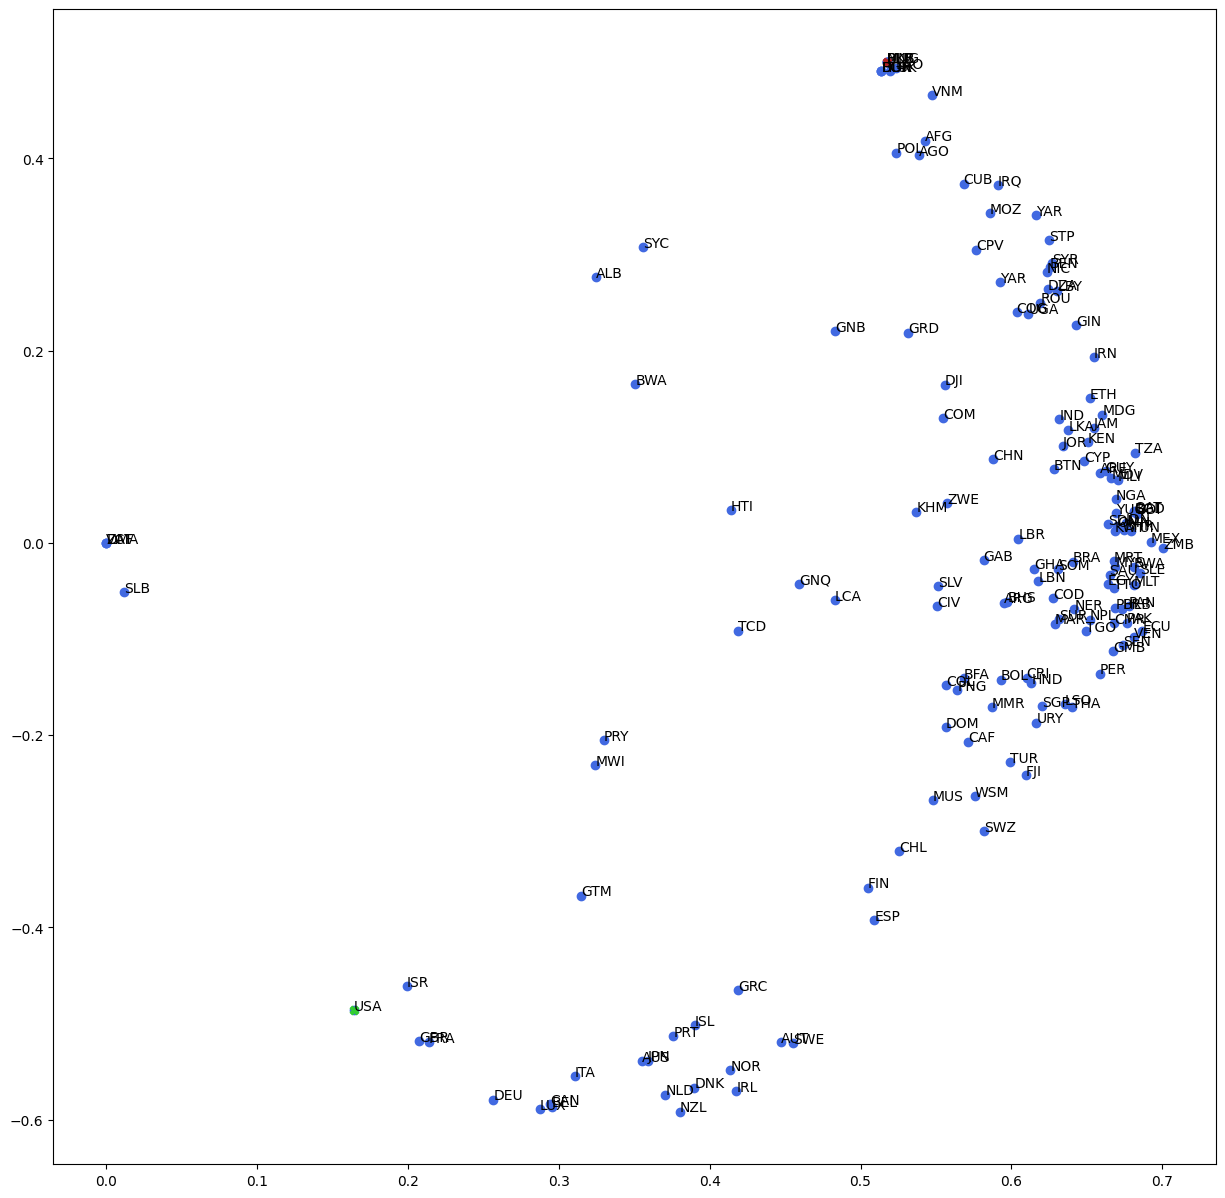

In [99]:
country_labels = []
missing_countries = []
for node, data in G_.nodes(data=True):
    if data['type'] == 'country':
        country_labels.append(data['country code'])
        if data['country code'] in ['USA', 'RUS']:
            print(node,data)
        

        
plt.figure(figsize =(15,15))
plt.scatter(x_ase_orig[country_indexes,1],x_ase_orig[country_indexes,3], c='royalblue',marker='o',label='Countries')
plt.scatter(x_ase_orig[0,1],x_ase_orig[0,3], c='limegreen',marker='X')
plt.scatter(x_ase_orig[55,1],x_ase_orig[55,3], c='firebrick',marker='X')
# Add labels to nodes
for i, label in enumerate(country_labels):
    plt.annotate(label, (x_ase_orig[country_indexes,1][i], x_ase_orig[country_indexes,3][i]))

# plt.ylim(0.325, 0.52)
# plt.xlim(0.4, 0.6)
plt.show()


In [91]:
np.where(x_ase_orig[country_indexes,3]>0.325)[0]

array([ 41,  44,  45,  52,  54,  55,  56, 130, 142])

In [98]:

selected_items = [country_labels[i] for i in np.where(x_ase_orig[country_indexes,3]>0.325)[0]]

print(selected_items)


['CUB', 'DDR', 'POL', 'HUN', 'CSK', 'BGR', 'RUS', 'UKR', 'BLR', 'AGO', 'MOZ', 'IRQ', 'YAR', 'AFG', 'MNG', 'LAO', 'VNM']


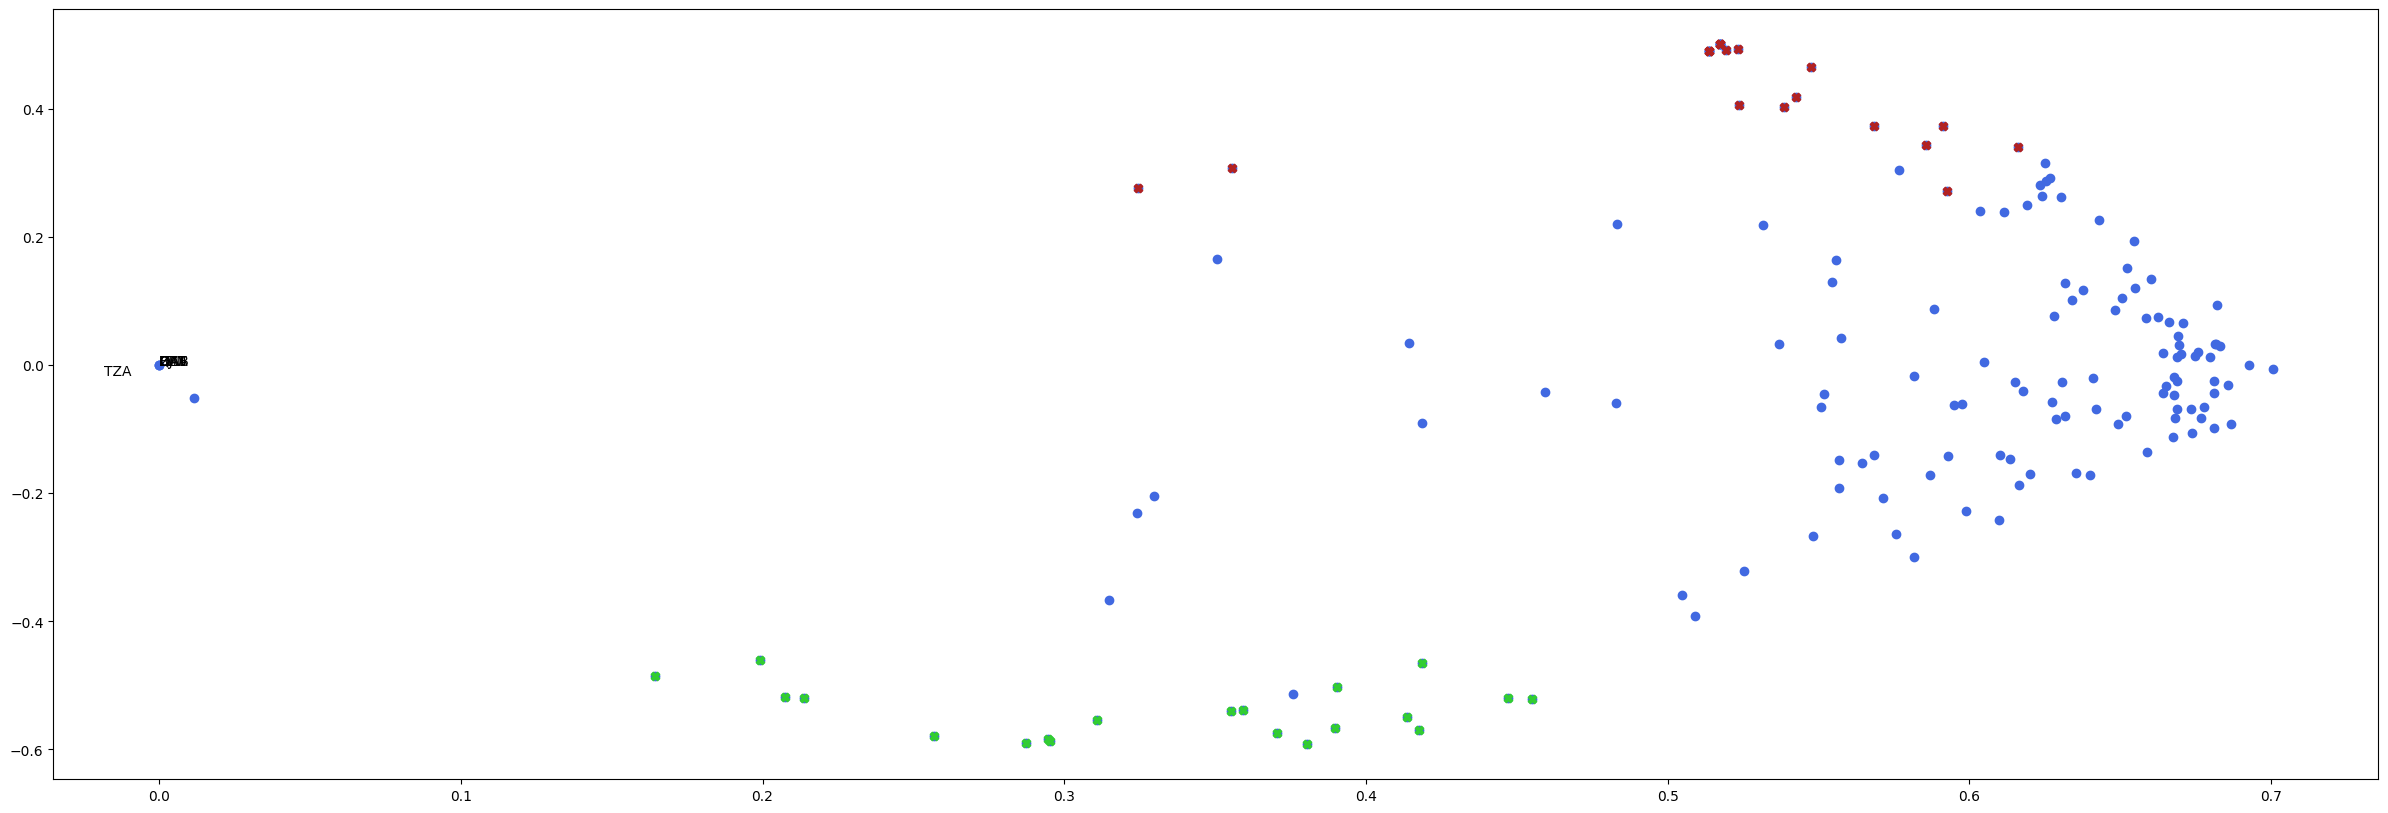

In [103]:
usa_alies = []
rusia_alies=[]
for node, data in G_.nodes(data=True):
    if data['type'] == 'country':
        if data['country code'] in ['USA','GBR', 'FRA', 'ISR', 'DEU', 'LUX', 'BEL', 'CAN', 'ITA', 'AUS', 'JPN', 'NLD', 'NZL', 'DNK', 'ISL', 'NOR', 'IRL', 'GRC','AUT', 'SWE']:
            usa_alies.append(node)
        if data['country code'] in ['RUS', 'CUB', 'DDR', 'POL', 'HUN', 'CSK', 'BGR', 'UKR', 'BLR', 'AGO', 'MOZ', 'IRQ', 'YAR', 'AFG', 'MNG', 'LAO', 'VNM', 'ALB', 'SYC']:
            rusia_alies.append(node)
                    
        
plt.figure(figsize =(30,10))
plt.scatter(x_ase_orig[country_indexes,1],x_ase_orig[country_indexes,3], c='royalblue',marker='o',label='Countries')
plt.scatter(x_ase_orig[usa_alies,1],x_ase_orig[usa_alies,3], c='limegreen',marker='X')
plt.scatter(x_ase_orig[rusia_alies,1],x_ase_orig[rusia_alies,3], c='firebrick',marker='X')
# Add labels to nodes
for i, label in enumerate(country_labels):
    plt.annotate(label, (x_ase[country_indexes,1][i], x_ase[country_indexes,3][i]))
plt.show()          


## Limited to certain countries

In [106]:
usa_alies = ['USA','GBR', 'FRA', 'ISR', 'DEU', 'LUX', 'BEL', 'CAN', 'ITA', 'AUS', 'JPN', 'NLD', 'NZL', 'DNK', 'ISL', 'NOR', 'IRL', 'GRC','AUT', 'SWE']
rusia_alies = ['RUS', 'CUB', 'DDR', 'POL', 'HUN', 'CSK', 'BGR', 'UKR', 'BLR', 'AGO', 'MOZ', 'IRQ', 'YAR', 'AFG', 'MNG', 'LAO', 'VNM', 'ALB', 'SYC']
votes_df_2 = votes_df[votes_df.Country.isin(usa_alies) | votes_df.Country.isin(rusia_alies)]

In [107]:
all_graphs = create_un_graphs(votes_df_2[votes_df_2.year==1980])
G = all_graphs.to_undirected()
# rename nodes
mapping = {node: i for i, node in enumerate(G.nodes())}
G_ = nx.relabel_nodes(G, mapping)

country_indexes = []
res_indexes = []
features = []

for node, data in G_.nodes(data=True):
    if data["type"] == "country":
        country_indexes.append(node)
        features.append(data['country_features'])
    else:
        res_indexes.append(node)
        features.append(data['res_features'])


unknown_edges = []

for u, v, data in G_.edges(data=True):
    if data['unknown']:
        unknown_edges.append((u,v))
        unknown_edges.append((v,u))
    

adj_matrix = nx.adjacency_matrix(G).todense().astype(int)

len(country_indexes), len(res_indexes), adj_matrix.shape[0]

(40, 103, 143)

In [108]:
## Create mask with unknown country votes

import torch
import random

num_nodes = adj_matrix.shape[0]

edge_index = torch.tensor(adj_matrix).nonzero().t().contiguous()

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
mask_unknown = torch.ones([num_nodes,num_nodes]).squeeze(0)

random.seed(42)
_alies = ['GBR', 'FRA', 'ISR', 'DEU', 'LUX', 'BEL', 'CUB', 'DDR', 'POL', 'HUN', 'CSK', 'BGR']

missing_countries = []

for node, data in G_.nodes(data=True):
    if data['type'] == 'country':
        if data['country code'] in _alies:
            missing_countries.append(node)

for i in missing_countries:
    votos = (torch.rand(1, num_nodes) < 0.2).int()
    mask[i,:] = votos
    mask[:,i] = votos
    
for edge in unknown_edges:
    u, v = edge
    mask_unknown[u,v] = 0
    
mask = mask*mask_unknown # Me aseguro que los unknown formen parte de la mask
inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask)*mask_unknown # Me aseguro no predecir sobre los unknown

### ASE Embeddings

In [109]:
## Calculate ASE Embeddings

from torch_geometric.utils import to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 

d = 4

## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)

torch.norm((x_ase@Q@x_ase.T - to_dense_adj(edge_index, max_num_nodes=num_nodes).squeeze(0))*mask)

tensor([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.]])


tensor(19.1387)

### GRDPG Embeddings

In [110]:
import sys
sys.path.append("../")
from models.RDPG_GD import GRDPG_GD_Armijo

x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index, max_num_nodes=num_nodes).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous(), max_num_nodes=num_nodes).squeeze(0)))

Iteraciones:  100
Loss:  tensor(7.8957)


### Link Prediction

In [111]:
## Create feature tensor 
features = torch.tensor(features)

## Split Train, Val, Test
from torch_geometric.data import Data
import torch_geometric.transforms as T

device = 'cuda'

masked_edge_index = masked_adj.nonzero().t().contiguous()

data = Data(x=features.float(), x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)
# torch.manual_seed(42)
# random_features=torch.rand([num_nodes, 12])
# data = Data(x=random_features.float(), x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

transform = T.Compose([
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])

train_data, val_data, test_data = transform(data)

#### GCN Embeddings

In [112]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(12, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

## Predict on entire masked graph
z = model.encode(data.x, data.edge_index)
final_edge_index = model.decode_all(z)

predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
# (adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2
((adj_matrix*inverted_mask_matrix)[missing_countries] == (predicted_adj*inverted_mask_matrix)[missing_countries]).sum()/len(missing_countries)/num_nodes

Epoch: 020, Loss: 0.6506, Val: 0.7010, Test: 0.7827
Epoch: 040, Loss: 0.5861, Val: 0.8685, Test: 0.8424
Epoch: 060, Loss: 0.5805, Val: 0.8962, Test: 0.8522
Epoch: 080, Loss: 0.5802, Val: 0.8897, Test: 0.8467
Epoch: 100, Loss: 0.5553, Val: 0.9019, Test: 0.8676
Final Test: 0.8498


tensor(0.7692)

#### ASE Embeddings

In [113]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(d+12, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_ase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_ase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_ase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
# (adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2
((adj_matrix*inverted_mask_matrix)[missing_countries] == (predicted_adj*inverted_mask_matrix)[missing_countries]).sum()/len(missing_countries)/num_nodes

Epoch: 020, Loss: 0.5849, Val: 0.9012, Test: 0.8404
Epoch: 040, Loss: 0.5769, Val: 0.8953, Test: 0.8478
Epoch: 060, Loss: 0.5665, Val: 0.9146, Test: 0.8732
Epoch: 080, Loss: 0.5576, Val: 0.9020, Test: 0.8709
Epoch: 100, Loss: 0.5447, Val: 0.9122, Test: 0.8707
Final Test: 0.8761


tensor(0.7587)

#### GRDPG Embeddings

In [114]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(d+12, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_grdpg), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_grdpg), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_grdpg), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_grdpg), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)

predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
# (adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2

((adj_matrix*inverted_mask_matrix)[missing_countries] == (predicted_adj*inverted_mask_matrix)[missing_countries]).sum()/len(missing_countries)/num_nodes

Epoch: 020, Loss: 0.6057, Val: 0.8748, Test: 0.8054
Epoch: 040, Loss: 0.5734, Val: 0.9113, Test: 0.8481
Epoch: 060, Loss: 0.5639, Val: 0.9121, Test: 0.8631
Epoch: 080, Loss: 0.5598, Val: 0.8955, Test: 0.8658
Epoch: 100, Loss: 0.5612, Val: 0.8907, Test: 0.8451
Final Test: 0.9065


tensor(0.7547)

# Country Analysis 

In [109]:
len(res_indexes)

95

Text(0.5, 0, 'node id')

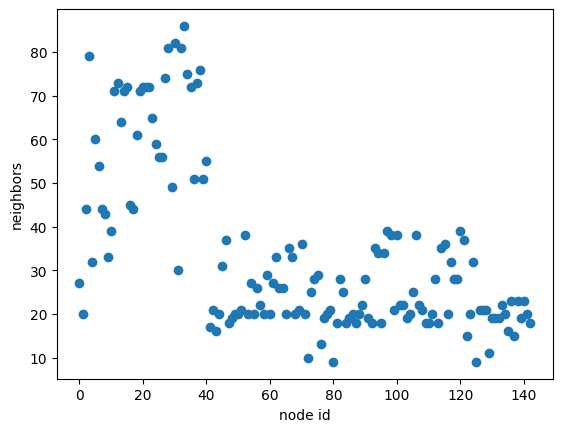

In [115]:
from sklearn import neighbors


unos = torch.ones(num_nodes)
vecinos = adj_matrix@unos
vecinos[res_indexes]


plt.scatter(np.arange(num_nodes), vecinos)
plt.ylabel('neighbors')
plt.xlabel('node id')

In [113]:
unos = torch.ones(num_nodes)
vecinos = masked_adj@unos
vecinos[res_indexes]

tensor([18., 10., 23.,  7., 18., 11., 13., 20., 16., 15., 13., 13., 18., 12.,
        18., 19., 17., 11., 17.,  8., 16., 17., 13., 19., 14., 16., 13., 10.,
        19., 16., 16., 18., 15.,  8.,  8., 14., 20., 13., 18., 16., 14., 26.,
        16.,  8., 19.,  7., 13., 19., 15., 20., 18., 17., 13.,  8., 12., 17.,
        16., 15., 17., 15., 19.,  8., 11., 16.,  9., 14., 11., 13., 12., 19.,
        10., 11., 13., 19., 15., 11., 11.,  8., 18., 13., 16., 11., 12., 16.,
         9., 11., 17., 16., 10., 10.,  9., 22., 16.,  8., 12.])

## 2018

In [43]:
country_indexes

[0,
 95,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262

In [46]:
x_ase[country_indexes,:]

tensor([[-0.1666, -0.1664,  0.1378,  ...,  0.0552,  0.2919, -0.2901],
        [-0.1536, -0.1533,  0.0284,  ...,  0.0917, -0.2405,  0.2366],
        [-0.0929, -0.0931,  0.0085,  ..., -0.0930,  0.0381, -0.0355],
        ...,
        [-0.1221, -0.1220,  0.1506,  ...,  0.0323, -0.1242,  0.1262],
        [-0.1801, -0.1800,  0.0098,  ..., -0.3226,  0.0949, -0.0849],
        [-0.1442, -0.1441,  0.1057,  ..., -0.1278, -0.1001,  0.1039]],
       device='cuda:0')

In [481]:
country_labels = []
usa_alies = []
rus_alies = []
for node, data in G_.nodes(data=True):
    if data['type'] == 'country':
        country_labels.append(data['country code'])
        if data['country code'] in ['MCO','MNE','BIH','ITA','ARM','RWA','NOR','COD','TZA','PRK','NRU','ISR','MDG']:
            usa_alies.append(node)
        if data['country code'] in ['LUX','GHA','BEN','OMN','LBN','FJI','KGZ','HUN', 'YEM','AFG','CAN','JPN']:
            rus_alies.append(node)  
# country_labels

tensor(20.1137, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


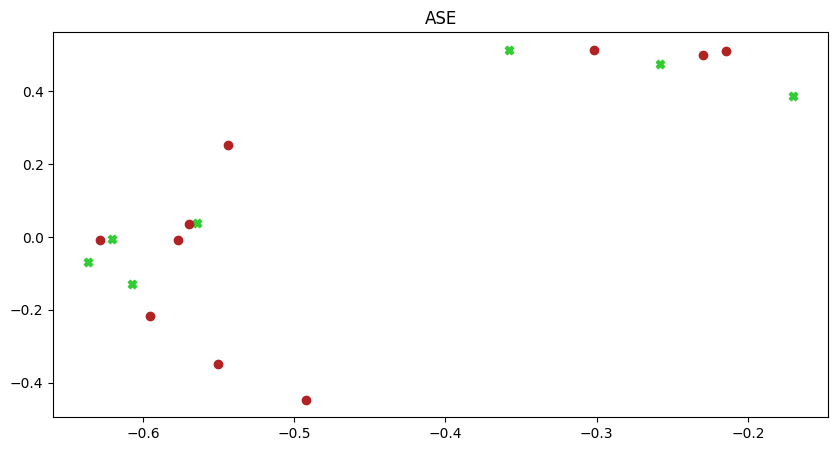

In [482]:
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')


# fig, axes = plt.subplots(1, 3, figsize =(15,5))
plt.figure(figsize =(10,5))
# plt.scatter(x_ase[country_indexes,0],x_ase[country_indexes,2], c='royalblue',marker='o',label='Countries')
plt.scatter(x_ase[usa_alies,0],x_ase[usa_alies,2], c='limegreen',marker='X')
plt.scatter(x_ase[rus_alies,0],x_ase[rus_alies,2], c='firebrick',marker='o')
# plt.scatter(x_ase[235,0],x_ase[235,2], c='firebrick',marker='X')

# Add labels to nodes
# for i, label in enumerate(country_labels):
#     plt.annotate(label, (x_ase[country_indexes,0][i], x_ase[country_indexes,2][i]))

# axes[0].scatter(x_ase[country_indexes,0],x_ase[country_indexes,2], c='royalblue',marker='o',label='Countries')
# axes[0].scatter(x_ase[279,0],x_ase[279,2], c='limegreen',marker='X',label='USA')
# axes[0].scatter(x_ase[176,0],x_ase[176,2], c='limegreen',marker='o',label='ISR')
# axes[0].scatter(x_ase[235,0],x_ase[235,2], c='firebrick',marker='X',label='RUS')

# axes[0].scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
# axes[0].scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
# axes[0].scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
# axes[0].scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
# axes[0].scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
# axes[0].scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
plt.title('ASE')

# axes[1].scatter(x_grdpg[n_P1_np:n_P1,0],x_grdpg[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
# axes[1].scatter(x_grdpg[:n_P1_np,0],x_grdpg[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
# axes[1].scatter(x_grdpg[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
# axes[1].scatter(x_grdpg[n_P1:n_P1+n_P2_np,0],x_grdpg[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
# axes[1].scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
# axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
# axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
# axes[1].set_title('GD')

# axes[2].scatter(x_glase[n_P1_np:n_P1,0],x_glase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
# axes[2].scatter(x_glase[:n_P1_np,0],x_glase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
# axes[2].scatter(x_glase[n_P1+n_P2_np:n_P1+n_P2,0],x_glase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
# axes[2].scatter(x_glase[n_P1:n_P1+n_P2_np,0],x_glase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
# axes[2].scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
# axes[2].scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
# axes[2].scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
# axes[2].set_title('LASE')
# plt.legend(loc='upper center', bbox_to_anchor=(-1, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

In [73]:
all_graphs = create_un_graphs(votes_df[(votes_df.Country.isin(['USA', 'RUS', 'CUB', 'ISR', 'FRA'])) & (votes_df.year>=2005)])

In [74]:
G = all_graphs.to_undirected()
# rename nodes
mapping = {node: i for i, node in enumerate(G.nodes())}
G_ = nx.relabel_nodes(G, mapping)

country_indexes = []
res_indexes = []
features = []

for node, data in G_.nodes(data=True):
    if data["type"] == "country":
        country_indexes.append(node)
        features.append(data['country_features'])
    else:
        res_indexes.append(node)
        features.append(data['res_features'])


unknown_edges = []

for u, v, data in G_.edges(data=True):
    if data['unknown']:
        unknown_edges.append((u,v))
        unknown_edges.append((v,u))
    


adj_matrix = nx.adjacency_matrix(G).todense().astype(int)

In [75]:
adj_matrix.shape

(1328, 1328)

In [76]:
## Create mask with not present senators for testing

import torch
import random

num_nodes = adj_matrix.shape[0]

edge_index = torch.tensor(adj_matrix).nonzero().t().contiguous()

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)

random.seed(42)
for i in country_indexes:
    votos = (torch.rand(1, num_nodes) < 0.1).int()
    mask[i,:] = votos
    mask[:,i] = votos
    

inverted_mask_matrix = torch.ones([num_nodes,num_nodes]).squeeze(0) - mask
    
## Create feature tensor 
features = torch.tensor(features)
features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], dtype=torch.float64)

In [78]:
## Calculate ASE Embeddings

from torch_geometric.utils import to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 

d = 6
torch.manual_seed(42)

## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)

torch.norm((x_ase@Q@x_ase.T - to_dense_adj(edge_index).squeeze(0))*mask)

/home/sofia/lase/lib/python3.10/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


tensor([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.]])


tensor(23.3810)

In [79]:
## Calculate GLASE Embeddings
import sys
sys.path.append("../")
from models.GLASE_unshared_normalized import gLASE 

gd_steps = 10
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 1000

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)

x_glase = out.detach().to('cpu')

tensor(23.3555, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(17.3572, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(12.9404, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(11.7529, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(11.2517, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(10.9362, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(10.7500, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(10.6623, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(10.6238, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(10.6043, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [80]:
## Split Train, Val, Test
from torch_geometric.data import Data
import torch_geometric.transforms as T

device = 'cuda'

masked_edge_index = masked_adj.nonzero().t().contiguous()

# data = Data(x=features.float(), x_ase=x_ase, x_glase=x_glase, edge_index=masked_edge_index)
torch.manual_seed(42)
random_features=torch.rand([num_nodes, 12])
data = Data(x=random_features.float(), x_ase=x_ase, x_glase=x_glase, edge_index=masked_edge_index)

transform = T.Compose([
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])

train_data, val_data, test_data = transform(data)

## GCN Embeddings

In [81]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(12, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

Epoch: 001, Loss: 0.6847, Val: 0.9911, Test: 0.9771
Epoch: 002, Loss: 0.6222, Val: 1.0000, Test: 1.0000
Epoch: 003, Loss: 0.8634, Val: 0.9956, Test: 0.9958
Epoch: 004, Loss: 0.6186, Val: 0.9911, Test: 0.9750
Epoch: 005, Loss: 0.6387, Val: 0.9867, Test: 0.9844
Epoch: 006, Loss: 0.6450, Val: 0.9956, Test: 0.9979
Epoch: 007, Loss: 0.6313, Val: 1.0000, Test: 1.0000
Epoch: 008, Loss: 0.6147, Val: 1.0000, Test: 1.0000
Epoch: 009, Loss: 0.6281, Val: 1.0000, Test: 1.0000
Epoch: 010, Loss: 0.6383, Val: 1.0000, Test: 1.0000
Epoch: 011, Loss: 0.6129, Val: 1.0000, Test: 1.0000
Epoch: 012, Loss: 0.6053, Val: 1.0000, Test: 1.0000
Epoch: 013, Loss: 0.6101, Val: 0.9956, Test: 1.0000
Epoch: 014, Loss: 0.6045, Val: 0.9956, Test: 1.0000
Epoch: 015, Loss: 0.6022, Val: 0.9956, Test: 1.0000
Epoch: 016, Loss: 0.5929, Val: 1.0000, Test: 1.0000
Epoch: 017, Loss: 0.5808, Val: 1.0000, Test: 1.0000
Epoch: 018, Loss: 0.5869, Val: 1.0000, Test: 1.0000
Epoch: 019, Loss: 0.5894, Val: 1.0000, Test: 1.0000
Epoch: 020, 

In [82]:
## Predict on entire masked graph
z = model.encode(data.x, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')

(adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2

tensor(0.9966)

## GLASE Embeddings

In [85]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(18, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_glase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_glase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_glase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.9287, Val: 0.9911, Test: 1.0000
Epoch: 002, Loss: 0.5824, Val: 1.0000, Test: 1.0000
Epoch: 003, Loss: 0.6552, Val: 1.0000, Test: 1.0000
Epoch: 004, Loss: 0.5735, Val: 0.9956, Test: 1.0000
Epoch: 005, Loss: 0.5546, Val: 1.0000, Test: 1.0000
Epoch: 006, Loss: 0.5570, Val: 1.0000, Test: 1.0000
Epoch: 007, Loss: 0.5433, Val: 1.0000, Test: 1.0000
Epoch: 008, Loss: 0.5274, Val: 1.0000, Test: 1.0000
Epoch: 009, Loss: 0.5231, Val: 1.0000, Test: 1.0000
Epoch: 010, Loss: 0.5246, Val: 1.0000, Test: 1.0000
Epoch: 011, Loss: 0.5066, Val: 1.0000, Test: 0.9990
Epoch: 012, Loss: 0.4957, Val: 1.0000, Test: 0.9948
Epoch: 013, Loss: 0.4773, Val: 1.0000, Test: 0.9927
Epoch: 014, Loss: 0.4644, Val: 0.9911, Test: 0.9927
Epoch: 015, Loss: 0.4561, Val: 0.9333, Test: 0.9938
Epoch: 016, Loss: 0.4575, Val: 0.9333, Test: 0.9938
Epoch: 017, Loss: 0.4511, Val: 0.9289, Test: 0.9854
Epoch: 018, Loss: 0.4366, Val: 0.9244, Test: 0.9719
Epoch: 019, Loss: 0.4286, Val: 0.9244, Test: 0.9563
Epoch: 020, 

In [87]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_glase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)

predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')

# (adj_matrix[not_present_countries][:,res_indexes]==predicted_adj[not_present_countries][:,res_indexes]).sum() / len(not_present_countries) / len(res_indexes)
(adj_matrix*inverted_mask_matrix == predicted_adj*inverted_mask_matrix).sum() / adj_matrix.shape[0]**2

tensor(0.9964)